## Diabetes Prediction using predict features dataset

<h4>Importing Libraries</h4>

In [1]:
import sys #This module provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. 
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import keras
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer 
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

**Loading the Dataset**

In [2]:
import time
# store starting time
begin_dataprep = time.time()

In [3]:
#read diabetes data 
df1 = pd.read_csv('diag_syn_great_diab_copy.csv')
#df1.drop(['Patient no'],axis=1,inplace=True)
df1.head()

,Patient no,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,Outcome
0,1,193,77,49,3.9,19,1,61,119,22.5,118,70,32,38,0.84,0
1,2,146,79,41,3.6,19,1,60,135,26.4,108,58,33,40,0.83,0
2,3,217,75,54,4.0,20,1,67,187,29.3,110,72,40,45,0.89,0
3,4,226,97,70,3.2,20,1,64,114,19.6,122,64,31,39,0.79,0
4,5,164,91,67,2.4,20,1,70,141,20.2,122,86,32,39,0.82,0


In [4]:
df1.columns

Index(['Patient no', 'cholesterol', 'glucose', 'hdl_chol', 'chol_hdl_ratio',
       'age', 'gender', 'height', 'weight', 'bmi', 'systolic_bp',
       'diastolic_bp', 'waist', 'hip', 'waist_hip_ratio', 'Outcome'],
      dtype='object')

In [5]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
df1['gender'] = df1['gender'].astype(int)
df1['gender'] = lbl.fit_transform(df1['gender'].astype(str))

In [6]:
columns=df1.columns

In [7]:
df1 = df1.reindex(columns=columns)

In [8]:
df1['Outcome'].value_counts(normalize=True)

0    0.543750
1    0.258333
2    0.197917
Name: Outcome, dtype: float64

In [9]:
train=df1
# dropping ALL duplicate values
train.drop_duplicates(keep = False, inplace = True)

In [10]:

target = 'Outcome'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [11]:
#Simple preprocessing
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 10:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

gender 2
Outcome 3
Set 3


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 0 to 479
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Patient no       480 non-null    int64  
 1   cholesterol      480 non-null    int64  
 2   glucose          480 non-null    int64  
 3   hdl_chol         480 non-null    int64  
 4   chol_hdl_ratio   480 non-null    float64
 5   age              480 non-null    int64  
 6   gender           480 non-null    int64  
 7   height           480 non-null    int64  
 8   weight           480 non-null    int64  
 9   bmi              480 non-null    float64
 10  systolic_bp      480 non-null    int64  
 11  diastolic_bp     480 non-null    int64  
 12  waist            480 non-null    int64  
 13  hip              480 non-null    int64  
 14  waist_hip_ratio  480 non-null    float64
 15  Outcome          480 non-null    int64  
 16  Set              480 non-null    int32  
dtypes: float64(3), i

In [13]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "Normal"
train.loc[train[target]==2, target] = "Prediabetic"
train.loc[train[target]==1, target] = "Diabetic"

In [14]:
#Define categorical features for categorical embeddings
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [15]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)

### Training

In [16]:
start_clf= time.time()

In [17]:
#Network parameters
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

C:\Users\admin\anaconda3\envs\pytorch-gpu-diab\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [18]:
train_indices.shape

(385,)

In [19]:
train_indices

Int64Index([  0,   1,   2,   3,   4,   5,   6,   9,  10,  11,
            ...
            464, 465, 466, 467, 469, 470, 472, 475, 476, 479],
           dtype='int64', length=385)

In [20]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [21]:
X_train.shape

(385, 15)

In [22]:
y_train.shape

(385,)

In [23]:
X_test.shape

(56, 15)

In [24]:
y_test.shape

(56,)

In [25]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [26]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

In [29]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['accuracy'],#,'balanced_accuracy'
        max_epochs=max_epochs , patience=20,
        batch_size=8, 
        num_workers=0,
        weights=1,
        drop_last=True,# changed because of the value error,ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 15])
        augmentations=aug, #aug, None
    )
    save_history.append(clf.history["valid_accuracy"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 1.26743 | train_accuracy: 0.32468 | valid_accuracy: 0.38462 |  0:00:01s
epoch 1  | loss: 1.02711 | train_accuracy: 0.55065 | valid_accuracy: 0.5641  |  0:00:02s
epoch 2  | loss: 0.89297 | train_accuracy: 0.55844 | valid_accuracy: 0.61538 |  0:00:03s
epoch 3  | loss: 0.88661 | train_accuracy: 0.58442 | valid_accuracy: 0.53846 |  0:00:05s
epoch 4  | loss: 0.71474 | train_accuracy: 0.62078 | valid_accuracy: 0.76923 |  0:00:06s
epoch 5  | loss: 0.81421 | train_accuracy: 0.6961  | valid_accuracy: 0.76923 |  0:00:07s
epoch 6  | loss: 0.70358 | train_accuracy: 0.78182 | valid_accuracy: 0.87179 |  0:00:09s
epoch 7  | loss: 0.6807  | train_accuracy: 0.83636 | valid_accuracy: 0.89744 |  0:00:10s
epoch 8  | loss: 0.66929 | train_accuracy: 0.76364 | valid_accuracy: 0.82051 |  0:00:11s
epoch 9  | loss: 0.66721 | train_accuracy: 0.87792 | valid_accuracy: 0.92308 |  0:00:13s
epoch 10 | loss: 0.6498  | train_accuracy: 0.87013 | valid_accuracy: 0.92308 |  0:00:14s
epoch 11 | loss: 0.68

C:\Users\admin\anaconda3\envs\pytorch-gpu-diab\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.26743 | train_accuracy: 0.32468 | valid_accuracy: 0.38462 |  0:00:01s
epoch 1  | loss: 1.02711 | train_accuracy: 0.55065 | valid_accuracy: 0.5641  |  0:00:02s
epoch 2  | loss: 0.89297 | train_accuracy: 0.55844 | valid_accuracy: 0.61538 |  0:00:03s
epoch 3  | loss: 0.88661 | train_accuracy: 0.58442 | valid_accuracy: 0.53846 |  0:00:05s
epoch 4  | loss: 0.71474 | train_accuracy: 0.62078 | valid_accuracy: 0.76923 |  0:00:06s
epoch 5  | loss: 0.81421 | train_accuracy: 0.6961  | valid_accuracy: 0.76923 |  0:00:07s
epoch 6  | loss: 0.70358 | train_accuracy: 0.78182 | valid_accuracy: 0.87179 |  0:00:09s
epoch 7  | loss: 0.6807  | train_accuracy: 0.83636 | valid_accuracy: 0.89744 |  0:00:10s
epoch 8  | loss: 0.66929 | train_accuracy: 0.76364 | valid_accuracy: 0.82051 |  0:00:11s
epoch 9  | loss: 0.66721 | train_accuracy: 0.87792 | valid_accuracy: 0.92308 |  0:00:13s
epoch 10 | loss: 0.6498  | train_accuracy: 0.87013 | valid_accuracy: 0.92308 |  0:00:14s
epoch 11 | loss: 0.68

C:\Users\admin\anaconda3\envs\pytorch-gpu-diab\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


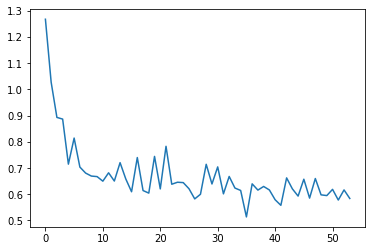

In [30]:
# plot losses
plt.plot(clf.history['loss'])

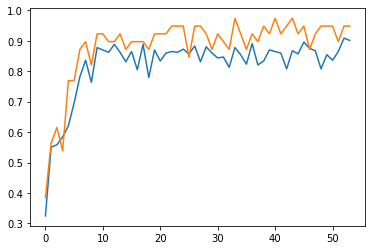

In [31]:
# plot auc
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

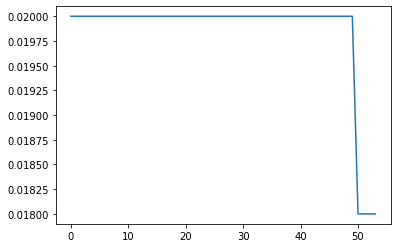

In [32]:
# plot learning rates
plt.plot(clf.history['lr'])

### Prediction

In [33]:
y_pred = clf.predict(X_test)

In [34]:
y_pred.shape

(56,)

In [35]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [36]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [37]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [38]:
print(multiclass_roc_auc_score(y_test, y_pred))

0.8092305165475898


In [39]:
X_test.shape

(56, 15)

In [40]:
y_test.shape

(56,)

Accuracy =  0.7857142857142857
-
[[15  0  0]
 [ 0 26  4]
 [ 8  0  3]]
-
              precision    recall  f1-score   support

    Diabetic       0.65      1.00      0.79        15
      Normal       1.00      0.87      0.93        30
 Prediabetic       0.43      0.27      0.33        11

    accuracy                           0.79        56
   macro avg       0.69      0.71      0.68        56
weighted avg       0.79      0.79      0.77        56

-


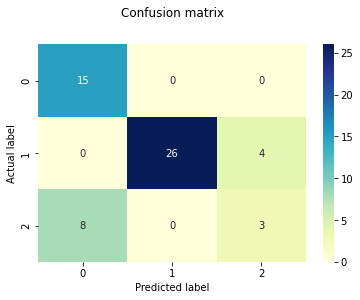

In [41]:
print('Accuracy = ', accuracy_score(y_test, y_pred))
print('-')
print(confusion_matrix(y_test,y_pred))
print('-')
print(classification_report(y_test,y_pred))
print('-')

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [42]:
pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Diabetic       0.65      1.00      0.79        15
      Normal       1.00      0.87      0.93        30
 Prediabetic       0.43      0.27      0.33        11

    accuracy                           0.79        56
   macro avg       0.69      0.71      0.68        56
weighted avg       0.79      0.79      0.77        56



In [44]:
end_clf= time.time()
time_clf = end_clf-start_clf
print('Time taken:',time_clf)

Time taken: 9875.662692308426


In [45]:
print('Time taken in minutes:',time_clf/60)

Time taken in minutes: 164.59437820514043
